In [431]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import os

import yaml
import hashlib

from visuals import visuals

In [432]:
from sympy import init_printing
init_printing() 


In [433]:
class SymbolicDiscreteDamage:
    def __init__(
        self, matpar, name="discrete generalised damage", slug="general damage"
    ):
        # self.state = state

        self.state = self._state(matpar)
        self.matpar = matpar
        self.sympar = {str(key): sp.symbols(str(key)) for key in matpar.keys()}
        self.str = name
        self.slug = slug

    def _state(self, matpar):
        _N = matpar["N"]

        u = sp.symbols([f"u{i}" for i in range(0, _N)])
        e = sp.symbols([f"e{i}" for i in range(1, _N + 1)])
        α = sp.symbols([f"α{i}" for i in range(1, _N + 1)])

        return {"u": u, "α": α, "e": e}

    def _s(self, αi):
        s = sp.Function("s")
        # s = 1/self._a(αi)
        return s(αi)

    def _a(self, αi):
        a = sp.Function("a")

        return a(αi)

    def _w(self, αi):
        w = sp.Function("w")

        return w(αi)

    def _elastic(self, state):
        e = state["e"]
        α = state["α"]
        _E0 = self.sympar["E0"]
        _N = self.sympar["N"]

        return (
            1
            / _N
            * sum([1.0 / 2.0 * _E0 * self._a(α[i]) * e[i] ** 2 for i in range(len(α))])
        )

    def _damage(self, state):
        _α = state["α"]
        _w1 = self.matpar["w1"]

        _N = self.matpar["N"]

        return 1 / _N * sum([_w1 * self._w(_α[i]) for i in range(len(_α))])
        # return _w1 * self._w(_α)

    def energy(self, state):
        """Total energy"""
        return self._elastic(state) + self._damage(state) - self.work(state)

    def work(self, state):
        return 0

    def boundary_condition(self):
        t = sp.symbols("t")
        N = sp.symbols("N")
        L = sp.symbols("L")

        return t * N / L

    # Explicit expressions
    def w(self, αi):
        return αi

    def a(self, αi):
        # γ = self.matpar["γ"]
        γ = self.sympar["γ"]

        return (1 - self._w(αi)) / ((γ - 1) * self._w(αi) + 1)

    def s(self, αi):
        return 1.0 / self.a(αi)

    def __str__(self):
        return self.str

In [434]:
import sympy as sp
import numpy as np


class ModelAnalysis:
    """Helper class to analyze (stability) properties of a model"""

    def __init__(self, model):
        self.model = model
        self.state = model.state
        self.matpar = model.matpar

        # Initialize symbols and derivatives
        _β = sp.symbols("β")
        _e = sp.symbols("e")
        self._β = _β
        self._e = _e
        self._initialize_derivatives()

        self.criterion()

    def _initialize_derivatives(self):
        """Initialize derivatives of internal state variables"""
        β = self._β
        self._s = self.model._s(β)
        self._sp = sp.diff(self._s, β, 1)
        self._spp = sp.diff(self._s, β, 2)

        self._a = self.model._a(β)
        self._ap = sp.diff(self._a, β, 1)
        self._app = sp.diff(self._a, β, 2)

        self._w = self.model._w(β)
        self._wp = sp.diff(self._w, β)
        self._wpp = sp.diff(self._w, β, 2)

    def _equilibrium_e(self):
        """Calculate equilibrium strain"""
        state = self.state
        t, L, N = sp.symbols("t L N")
        _S = sum([self.model._s(αi) for αi in state["α"]])
        datum = self.model.boundary_condition()

        _e = [(datum * self.model._s(αi) / _S).simplify() for αi in state["α"]]
        return _e

    def _elastic_energy_fc_alpha(self):
        """Calculate elastic energy with equilibrium strain"""
        _ei = self._equilibrium_e()
        state = self.state
        equilibrium_subs = {v[0]: v[1] for v in zip(state["e"], _ei)}
        subs_s_inverse = {
            sp.Function("a")(sp.Symbol(a.name)): 1 / self.model._s(a)
            for a in state["α"]
        }
        return (
            self.model._elastic(state)
            .subs(equilibrium_subs)
            .subs(subs_s_inverse)
            .simplify()
        )

    def _state_split(self, m, matpar):
        """Split the state into homogeneous and bifurcated parts"""
        state = self.state
        assert m < matpar["N"]

        _bif_α = [state["α"][k + 1] for k in range(m)]
        _bif_e = [state["e"][k + 1] for k in range(m)]

        _homo_α = set(state["α"]) - set(_bif_α)
        _homo_e = set(state["e"]) - set(_bif_e)

        return _bif_α, _homo_α, _bif_e, _homo_e

    def _state_homog_substitutions(self):
        """Substitutions for the homogeneous state"""
        αt = sp.symbols("α_t")
        et = sp.symbols("e_t")
        state = self.model.state
        _subs_αh = {a: αt for a in state["α"]}
        _subs_eh = {e: et for e in state["e"]}
        return _subs_αh, _subs_eh

    def _state_bifurcation_substitutions(self, m, matpar):
        """Computes substitutions for bifurcated states"""
        state = self.state
        assert m < matpar["N"]
        _bif, _homo, _bif_e, _homo_e = self._state_split(m, matpar)
        _αb = sp.symbols("α_t")
        _eb = sp.symbols("e_t")
        αt = sp.symbols("α^*")
        et = sp.symbols("e^*")

        _subs_αb = {a: _αb for a in _bif}
        _subs_eb = {e: _eb for e in _bif_e}
        _subs_αt = {a: αt for a in _homo}
        _subs_et = {e: et for e in _homo_e}

        return {**_subs_αb, **_subs_αt}, {**_subs_eb, **_subs_et}

    def criterion(self):
        """Damage onset criterion"""
        model, state = self.model, self.state
        t, L, N = sp.symbols("t L N")

        β = self._β
        e = self._e

        _e0 = t / L
        _α0 = 0

        _homogeneous_damage = {a: β for a in state["α"]}
        _homogeneous_strain = {ε: e for ε in state["e"]}

        _crit = sp.diff(
            model.energy(state).subs(_homogeneous_damage).subs(_homogeneous_strain), β
        ).subs({e: _e0, β: _α0})

        self.crit = 1 / N * _crit
        return self.crit.simplify()

    def critical_load(self, matpar={}):
        """Critical load calculation"""
        _a = sp.Function("a")
        _w = sp.Function("w")
        t = sp.symbols("t")

        criterion = self.crit.replace(_a, self.model.a).replace(_w, self.model.w)
        tc = sp.solve(criterion, t)

        if matpar:
            tc = [_tc.subs(matpar) for _tc in tc if _tc.subs(matpar).is_positive]

        return tc, criterion

    def energy_fc_alpha(self):
        """Energy function for alpha"""
        _ei = self._equilibrium_e()
        state = self.state
        equilibrium_subs = {v[0]: v[1] for v in zip(state["e"], _ei)}
        subs_s_inverse = {
            sp.Function("a")(sp.Symbol(a.name)): 1 / self.model._s(a)
            for a in state["α"]
        }

        return (
            self.model.energy(state)
            .subs(equilibrium_subs)
            .subs(subs_s_inverse)
            .simplify()
        )

    def homogeneous_α(self, state, matpar={}):
        """Solve the homogeneous evolution law for damage"""
        αt = sp.symbols("α_t")
        state = self.state

        if matpar:
            return [
                sol.subs(matpar)
                for sol in list(
                    map(sp.simplify, sp.solve(self.evo_α(state, matpar), αt))
                )
            ]
        else:
            return list(map(sp.simplify, sp.solve(self.evo_α(state), αt)))

    def homogeneous_damage(self, matpar={}):
        """Calculate homogeneous damage"""
        idx = self.positive_solution_wrt_t(matpar)
        _alpha = self.homogeneous_α(matpar)[idx].subs(matpar)
        tc = self.critical_load(matpar)[0][0]
        t = sp.symbols("t")

        alpha = sp.Piecewise((_alpha, t >= tc), (0, t < tc))
        return alpha

    def evo_α(self, state, matpar={}):
        """Evolution law for damage"""
        αt = sp.symbols("α_t")
        _a = sp.Function("a")
        _w = sp.Function("w")

        subs_homog_α, _ = self._state_homog_substitutions()

        energy = (
            self.energy_fc_alpha()
            .subs(subs_homog_α)
            .replace(sp.Function("s"), self.model.s)
            .replace(_w, self.model.w)
            .doit()
        )

        if matpar:
            energy = energy.subs(matpar)

        return sp.diff(energy, αt).simplify()

    def positive_solution_wrt_t(self, matpar={}):
        """Find positive solution with respect to t"""
        idx = np.where(
            np.array(
                [
                    sp.diff(eq, sp.symbols("t")).subs(matpar)
                    for eq in self.homogeneous_α(matpar)
                ]
            )
            > 0
        )[0]
        return idx[0]

    def _elastic_energy_m_bifurcations(self, m):
        state = self.state
        n = len(state["α"])
        # n = N
        N, t, L, E0 = sp.symbols("N t L E0")
        # _s = model.model.s
        _s = sp.Function("s")

        at = sp.symbols("α_t")
        ax = sp.symbols("α^*")
        return 1.0 / 2.0 * E0 * (N * t / L) ** 2 * 1 / ((N - m) * _s(ax) + m * _s(at))

    def energy_m_bifurcations(self, m):
        state = self.state
        n = len(state["α"])
        at = sp.symbols("α_t")
        ax = sp.symbols("α^*")

        return self._elastic_energy_m_bifurcations(m) + self.matpar["w1"] * (
            m * self.model.w(at) + (n - m) * self.model.w(ax)
        )

In [435]:
_a = sp.Function('a')
_w = sp.Function('w')

_N = 3

_α = sp.symbols("α")
β = sp.symbols('β')

_matpar = {"N": 3, "γ": 2, "E0": 1, "w1": 1, "L": 1}
# matpar = {"N": N, "γ": γ, "E0": E0, "w1": w1, "L": L}

atls = SymbolicDiscreteDamage(_matpar)

system = ModelAnalysis(atls)
system.criterion()


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman


        2 ⎛d       ⎞│          ⎛d       ⎞│   
1.5⋅E₀⋅t ⋅⎜──(a(β))⎟│      1.0⋅⎜──(w(β))⎟│   
          ⎝dβ      ⎠│β=0       ⎝dβ      ⎠│β=0
──────────────────────── + ──────────────────
          2  2                     N         
         L ⋅N                                

In [436]:
sp.latex(_)

'\\frac{1.5 E_{0} t^{2} \\left. \\frac{d}{d β} a{\\left(β \\right)} \\right|_{\\substack{ β=0 }}}{L^{2} N^{2}} + \\frac{1.0 \\left. \\frac{d}{d β} w{\\left(β \\right)} \\right|_{\\substack{ β=0 }}}{N}'

In [437]:
atls.state

{'u': [u0, u1, u2], 'α': [α1, α2, α3], 'e': [e1, e2, e3]}

In [438]:
atls._elastic(system.state)

         2                  2                  2      
0.5⋅E₀⋅e₁ ⋅a(α₁) + 0.5⋅E₀⋅e₂ ⋅a(α₂) + 0.5⋅E₀⋅e₃ ⋅a(α₃)
──────────────────────────────────────────────────────
                          N                           

In [439]:
system.criterion().simplify()

        2 ⎛d       ⎞│          ⎛d       ⎞│   
1.5⋅E₀⋅t ⋅⎜──(a(β))⎟│      1.0⋅⎜──(w(β))⎟│   
          ⎝dβ      ⎠│β=0       ⎝dβ      ⎠│β=0
──────────────────────── + ──────────────────
          2  2                     N         
         L ⋅N                                

In [440]:
(system.criterion()  \
    .replace(_a, system.model.a )    \
    .replace(_w, system.model.w).doit()).simplify()

          2        
  1.5⋅E₀⋅t ⋅γ   1.0
- ─────────── + ───
      2  2       N 
     L ⋅N          

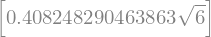

In [441]:
tc, criterion = system.critical_load(_matpar)
tc

In [442]:
system._state_homog_substitutions()

({α₁: αₜ, α₂: αₜ, α₃: αₜ}, {e₁: eₜ, e₂: eₜ, e₃: eₜ})

In [443]:
system._equilibrium_e()

⎡        N⋅t⋅s(α₁)                  N⋅t⋅s(α₂)                  N⋅t⋅s(α₃)      
⎢─────────────────────────, ─────────────────────────, ───────────────────────
⎣L⋅(s(α₁) + s(α₂) + s(α₃))  L⋅(s(α₁) + s(α₂) + s(α₃))  L⋅(s(α₁) + s(α₂) + s(α₃

  ⎤
──⎥
))⎦

In [444]:
sum([e**2 for e in system._equilibrium_e()]).simplify()

 2  2 ⎛ 2        2        2    ⎞
N ⋅t ⋅⎝s (α₁) + s (α₂) + s (α₃)⎠
────────────────────────────────
   2                        2   
  L ⋅(s(α₁) + s(α₂) + s(α₃))    

In [445]:
np.sum([e.subs({a: 0 for a in system.state['α']}) for e in system._equilibrium_e()])

In [446]:
system.energy_fc_alpha().simplify()

          2                   2                   2                           
0.5⋅E₀⋅N⋅t ⋅s(α₁) + 0.5⋅E₀⋅N⋅t ⋅s(α₂) + 0.5⋅E₀⋅N⋅t ⋅s(α₃) + 0.333333333333333⋅
──────────────────────────────────────────────────────────────────────────────
                                                    2                        2
                                                   L ⋅(s(α₁) + s(α₂) + s(α₃)) 

 2                        2                        
L ⋅(s(α₁) + s(α₂) + s(α₃)) ⋅(w(α₁) + w(α₂) + w(α₃))
───────────────────────────────────────────────────
                                                   
                                                   

In [447]:
system._elastic_energy_fc_alpha().simplify()

                 2        
       0.5⋅E₀⋅N⋅t         
──────────────────────────
 2                        
L ⋅(s(α₁) + s(α₂) + s(α₃))

In [448]:
subs_homog_α, subs_homog_e =  system._state_homog_substitutions()
subs_homog_α, subs_homog_e

({α₁: αₜ, α₂: αₜ, α₃: αₜ}, {e₁: eₜ, e₂: eₜ, e₃: eₜ})

In [449]:
system.energy_fc_alpha().subs(subs_homog_α)

          2              2  2          
1.5⋅E₀⋅N⋅t ⋅s(αₜ) + 9.0⋅L ⋅s (αₜ)⋅w(αₜ)
───────────────────────────────────────
                 2  2                  
              9⋅L ⋅s (αₜ)              

In [450]:
(system.energy_fc_alpha().subs(subs_homog_α)).subs(_matpar)

     2              2          
4.5⋅t ⋅s(αₜ) + 9.0⋅s (αₜ)⋅w(αₜ)
───────────────────────────────
               2               
            9⋅s (αₜ)           

In [451]:
_a = sp.Function('a')
_w = sp.Function('w')
_s = sp.Function('s')


$$
\begin{aligned}
\mathcal E_N (e, \alpha) &=  E_0\sum_{i=0}^N \frac{1}{2}    a(\alpha_i)  e_i^2  + \sum_{i=0}^N {w_1}w(\alpha_i) \\
{\mathcal E} (u, \alpha) = \frac{\mathcal E_N (e, \alpha)}{N} &=  E_0 N\sum_{i=0}^N \frac{1}{2}  a(\alpha_i)  (u_i-u_{i-1})^2  + \frac{w_1}{N} \sum_{i=0}^N w(\alpha_i) 
\end{aligned}
$$

In [452]:
system.state["α"][0]

α₁

In [453]:
# Keeping track of both symboilic and explicit expressions

atls._s(sp.symbols('α')), atls.s(sp.symbols('α'))

⎛      1.0⋅((γ - 1)⋅w(α) + 1)⎞
⎜s(α), ──────────────────────⎟
⎝             1 - w(α)       ⎠

In [454]:
atls.energy(system.state).factor()

    ⎛         2                  2                  2                         
0.5⋅⎝1.0⋅E₀⋅e₁ ⋅a(α₁) + 1.0⋅E₀⋅e₂ ⋅a(α₂) + 1.0⋅E₀⋅e₃ ⋅a(α₃) + 0.66666666666666
──────────────────────────────────────────────────────────────────────────────
                                                                       N      

                                                                 ⎞
7⋅N⋅w(α₁) + 0.666666666666667⋅N⋅w(α₂) + 0.666666666666667⋅N⋅w(α₃)⎠
──────────────────────────────────────────────────────────────────
                                                                  

In [455]:
system.model.energy(system.state)

# _homogeneous_damage = {a: β for a in state["α"]}
# _homogeneous_strain = {e: model._e for e in state["e"]}
# _homogeneous_damage, _homogeneous_strain


                                                                              
                                                                              
0.333333333333333⋅w(α₁) + 0.333333333333333⋅w(α₂) + 0.333333333333333⋅w(α₃) + 
                                                                              

         2                  2                  2      
0.5⋅E₀⋅e₁ ⋅a(α₁) + 0.5⋅E₀⋅e₂ ⋅a(α₂) + 0.5⋅E₀⋅e₃ ⋅a(α₃)
──────────────────────────────────────────────────────
                          N                           

In [456]:
_sound = {a: 0 for a in system.state["α"]}
_sound

{α₁: 0, α₂: 0, α₃: 0}

## Model Analysis

- (constitutive assumptions)
- equilibrium
- homogeneous solution
- homogeneous energy
- bifurcations
- stability

In [457]:
atls = SymbolicDiscreteDamage(_matpar)
system = ModelAnalysis(atls)
(system.criterion()).subs(_matpar)

                   2 ⎛d       ⎞│                        ⎛d       ⎞│   
0.166666666666667⋅t ⋅⎜──(a(β))⎟│    + 0.333333333333333⋅⎜──(w(β))⎟│   
                     ⎝dβ      ⎠│β=0                     ⎝dβ      ⎠│β=0

## First order

### homogeneous solution

In [458]:
_ei = system._equilibrium_e()
equilibrium_subs = {v[0]: v[1] for v in zip(system.state["e"], _ei)}

equilibrium_subs

⎧            N⋅t⋅s(α₁)                      N⋅t⋅s(α₂)                      N⋅t
⎨e₁: ─────────────────────────, e₂: ─────────────────────────, e₃: ───────────
⎩    L⋅(s(α₁) + s(α₂) + s(α₃))      L⋅(s(α₁) + s(α₂) + s(α₃))      L⋅(s(α₁) + 

⋅s(α₃)        ⎫
──────────────⎬
s(α₂) + s(α₃))⎭

In [459]:
system.energy_fc_alpha() 


          2                   2                   2                           
0.5⋅E₀⋅N⋅t ⋅s(α₁) + 0.5⋅E₀⋅N⋅t ⋅s(α₂) + 0.5⋅E₀⋅N⋅t ⋅s(α₃) + 0.333333333333333⋅
──────────────────────────────────────────────────────────────────────────────
                                                    2                        2
                                                   L ⋅(s(α₁) + s(α₂) + s(α₃)) 

 2                        2                        
L ⋅(s(α₁) + s(α₂) + s(α₃)) ⋅(w(α₁) + w(α₂) + w(α₃))
───────────────────────────────────────────────────
                                                   
                                                   

In [460]:
system.evo_α(system.state)

                          2          2   2  2        2   2          2   2     
- 0.166666666666667⋅E₀⋅N⋅t ⋅γ + 1.0⋅L ⋅αₜ ⋅γ  - 2.0⋅L ⋅αₜ ⋅γ + 1.0⋅L ⋅αₜ  + 2.
──────────────────────────────────────────────────────────────────────────────
                       2 ⎛      2  2         2           2                    
                      L ⋅⎝1.0⋅αₜ ⋅γ  - 2.0⋅αₜ ⋅γ + 1.0⋅αₜ  + 2.0⋅αₜ⋅γ - 2.0⋅αₜ

   2             2           2
0⋅L ⋅αₜ⋅γ - 2.0⋅L ⋅αₜ + 1.0⋅L 
──────────────────────────────
      ⎞                       
 + 1.0⎠                       

In [461]:
system.evo_α(system.state, _matpar)

   2         2               
- t  + 1.0⋅αₜ  + 2.0⋅αₜ + 1.0
─────────────────────────────
          2                  
    1.0⋅αₜ  + 2.0⋅αₜ + 1.0   

In [462]:
system.homogeneous_α(system.state)

⎡                           ________                             ________⎤
⎢-L - 0.408248290463863⋅t⋅╲╱ E₀⋅N⋅γ   -L + 0.408248290463863⋅t⋅╲╱ E₀⋅N⋅γ ⎥
⎢───────────────────────────────────, ───────────────────────────────────⎥
⎣            L⋅(γ - 1.0)                          L⋅(γ - 1.0)            ⎦

In [463]:
system.homogeneous_α(system.state, _matpar)

In [464]:
idx = system.positive_solution_wrt_t(_matpar)
idx

1

In [465]:
sp.simplify(system.homogeneous_α(_matpar)[idx]).subs(_matpar)

### Homogeneous varying N

<>:43: SyntaxWarning: invalid escape sequence '\d'
<>:43: SyntaxWarning: invalid escape sequence '\d'
/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_517/2746674941.py:43: SyntaxWarning: invalid escape sequence '\d'
  ax.plot(_loads, _f(_loads), c="k", lw=5, label=f"$\dot \\alpha_N \geq 0, N={_N}$")


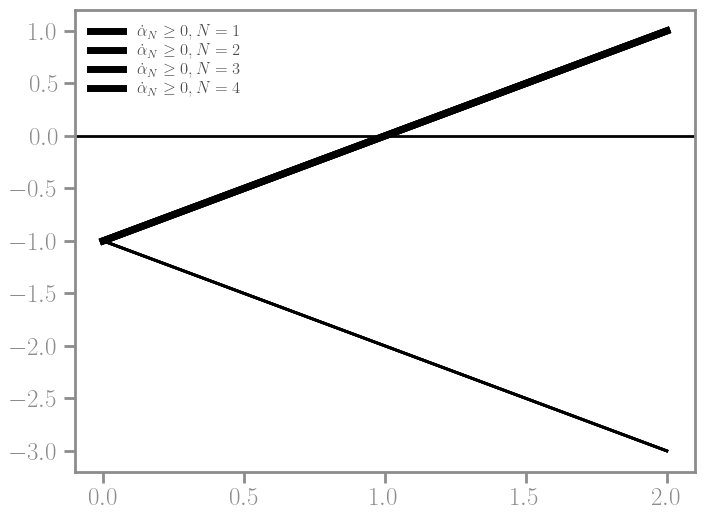

In [466]:
N = sp.symbols("N")
t = sp.symbols("t")
_a = sp.Function("a")
_w = sp.Function("w")
γ = sp.symbols("γ")
E0, L, w1, σc = sp.symbols("E0 L w1 σc")
β = sp.symbols("β")

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for _N in range(1, 5):
    u = sp.symbols([f"u{i}" for i in range(0, _N)])
    e = sp.symbols([f"e{i}" for i in range(1, _N + 1)])
    α = sp.symbols([f"α{i}" for i in range(1, _N + 1)])
    _α = sp.symbols("α")

    state = {"u": u, "α": α, "e": e}
    _matpar = {"N": _N, "γ": 2, "E0": 1, "w1": 1, "L": 1}
    matpar = {"N": N, "γ": γ, "E0": E0, "w1": w1, "L": L}
    _loads = np.linspace(0.0, float(γ.subs(_matpar)), 30)

    atls = SymbolicDiscreteDamage(_matpar)

    system = ModelAnalysis(atls)
    # print(model.criterion())

    # subs_homog_α, subs_homog_e =  model._state_homog_substitutions(state)

    # Substitutions to compute homogeneous solutions
    # print(subs_homog_α, subs_homog_e)
    # print(model.homogeneous_α(state, _matpar))
    idx = system.positive_solution_wrt_t(_matpar)
    # print(idx)

    evos = [evo.subs(_matpar) for evo in system.homogeneous_α(_matpar)]
    evo_x = evos[idx].subs(_matpar)

    for alphas in evos:
        _f = sp.lambdify(t, alphas.subs(_matpar), "numpy")
        plt.plot(_loads, _f(_loads), c="k")

    _f = sp.lambdify(t, evo_x, "numpy")
    ax.plot(_loads, _f(_loads), c="k", lw=5, label=f"$\dot \\alpha_N \geq 0, N={_N}$")


ax.axhline(0, c="k")
ax.legend()

<lambdifygenerated-124>:2: RuntimeWarning: divide by zero encountered in divide
  return 0.125*(1 - select([greater_equal(t, 1),True], [1.0*t - 1.0,0], default=nan))**2*(4.0*t**2*(select([greater_equal(t, 1),True], [1.0*t - 1.0,0], default=nan) + 1)/(1 - select([greater_equal(t, 1),True], [1.0*t - 1.0,0], default=nan)) + 8.0*(select([greater_equal(t, 1),True], [1.0*t - 1.0,0], default=nan) + 1)**2*select([greater_equal(t, 1),True], [1.0*t - 1.0,0], default=nan)/(1 - select([greater_equal(t, 1),True], [1.0*t - 1.0,0], default=nan))**2)/(select([greater_equal(t, 1),True], [1.0*t - 1.0,0], default=nan) + 1)**2
<lambdifygenerated-124>:2: RuntimeWarning: invalid value encountered in multiply
  return 0.125*(1 - select([greater_equal(t, 1),True], [1.0*t - 1.0,0], default=nan))**2*(4.0*t**2*(select([greater_equal(t, 1),True], [1.0*t - 1.0,0], default=nan) + 1)/(1 - select([greater_equal(t, 1),True], [1.0*t - 1.0,0], default=nan)) + 8.0*(select([greater_equal(t, 1),True], [1.0*t - 1.0,0], defa

Text(0.5, 0, 't')

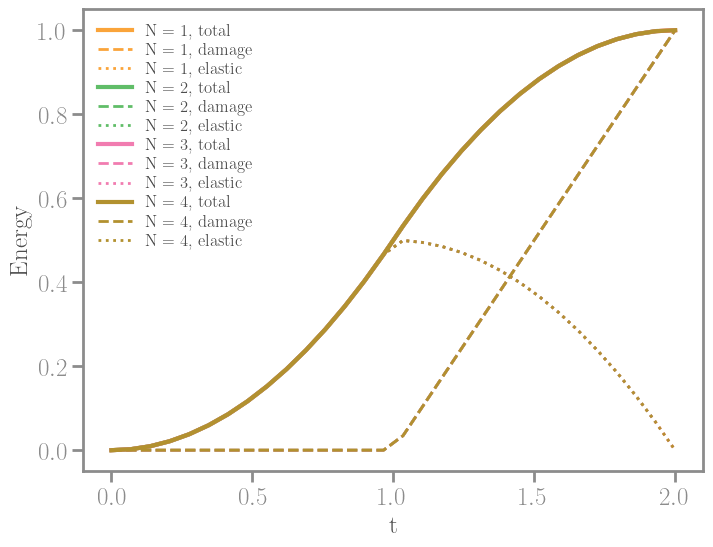

In [467]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for _N in range(1, 5):
    u = sp.symbols([f"u{i}" for i in range(0, _N)])
    e = sp.symbols([f"e{i}" for i in range(1, _N + 1)])
    α = sp.symbols([f"α{i}" for i in range(1, _N + 1)])
    _α = sp.symbols("α")

    state = {"u": u, "α": α, "e": e}
    _matpar = {"N": _N, "γ": 2, "E0": 1, "w1": 1, "L": 1}
    matpar = {"N": N, "γ": γ, "E0": E0, "w1": w1, "L": L}
    _loads = np.linspace(0.0, float(γ.subs(_matpar)), 30)

    atls = SymbolicDiscreteDamage(_matpar)

    system = ModelAnalysis(atls)

    subs_homog_α, subs_homog_e = system._state_homog_substitutions()
    alpha = system.homogeneous_damage(_matpar)

    _en = (
        system.energy_fc_alpha()
        .subs(subs_homog_α)
        .subs(_matpar)
        .replace(_a, system.model.a)
        .replace(sp.Function("s"), atls.s)
        .replace(_w, system.model.w)
        .subs(_matpar)
        .subs({sp.symbols("α_t"): alpha})
    )

    _energy_damage = (
        system.model._damage(state)
        .subs(subs_homog_α)
        .subs(_matpar)
        .replace(_w, system.model.w)
        .subs({sp.symbols("α_t"): alpha})
    )

    _f = sp.lambdify(t, _en.subs(_matpar), "numpy")
    _f1 = sp.lambdify(t, _energy_damage, "numpy")
    ax.plot(_loads, _f(_loads), label=f"N = {_N}, total", lw=3, c=f"C{_N}")
    ax.plot(_loads, _f1(_loads), c=f"C{_N}", label=f"N = {_N}, damage", ls="--")
    ax.plot(
        _loads, _f(_loads) - _f1(_loads), c=f"C{_N}", label=f"N = {_N}, elastic", ls=":"
    )

ax.legend()
ax.set_ylabel("Energy")
ax.set_xlabel("t")

### Plots of homogeneous response

In [468]:
subs_homog_α, subs_homog_e =  system._state_homog_substitutions()

# Substitutions to compute homogeneous solutions
subs_homog_α, subs_homog_e

({α₁: αₜ, α₂: αₜ, α₃: αₜ, α₄: αₜ}, {e₁: eₜ, e₂: eₜ, e₃: eₜ, e₄: eₜ})

In [469]:
evos = [evo.subs(_matpar) for evo in system.homogeneous_α(_matpar)]
evos[idx].subs(_matpar)

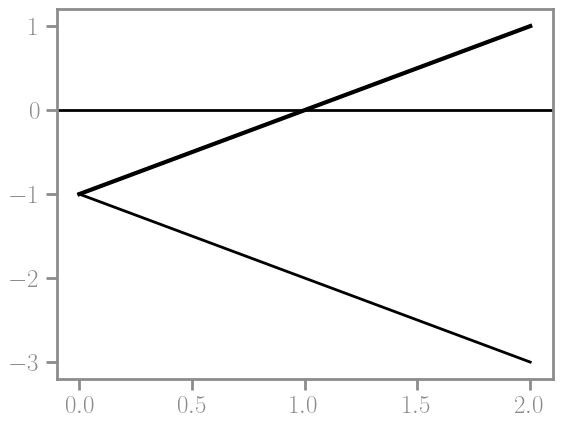

In [470]:
evos = [evo.subs(_matpar) for evo in system.homogeneous_α(_matpar)]
_loads = np.linspace(0., float(γ.subs(_matpar)), 30)
evo_x = evos[idx].subs(_matpar)

for alphas in evos:
    _f = sp.lambdify(t, alphas.subs(_matpar), 'numpy')
    plt.plot(_loads, _f(_loads), c='k')

_f = sp.lambdify(t, evo_x, 'numpy')
plt.plot(_loads, _f(_loads), c='k', lw=3)


plt.axhline(0, c='k')

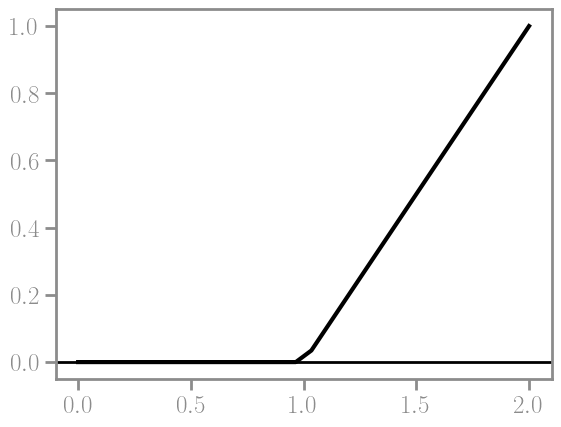

In [471]:
alpha = system.homogeneous_damage(_matpar)

_f = sp.lambdify(t, alpha.subs(_matpar), 'numpy')
plt.plot(_loads, _f(_loads), c='k', lw=3)

plt.axhline(0, c='k')

In [472]:
_en = system.energy_fc_alpha().subs(subs_homog_α)    \
            .subs(_matpar) \
            .replace(_a, system.model.a) \
            .replace(sp.Function('s'), atls.s)      \
            .replace(_w, system.model.w)  \
            .subs(_matpar)
_en

                 ⎛     2                            2⎞
               2 ⎜8.0⋅t ⋅(αₜ + 1)   16.0⋅αₜ⋅(αₜ + 1) ⎟
0.0625⋅(1 - αₜ) ⋅⎜─────────────── + ─────────────────⎟
                 ⎜     1 - αₜ                   2    ⎟
                 ⎝                      (1 - αₜ)     ⎠
──────────────────────────────────────────────────────
                              2                       
                      (αₜ + 1)                        

Text(0.5, 0, 't')

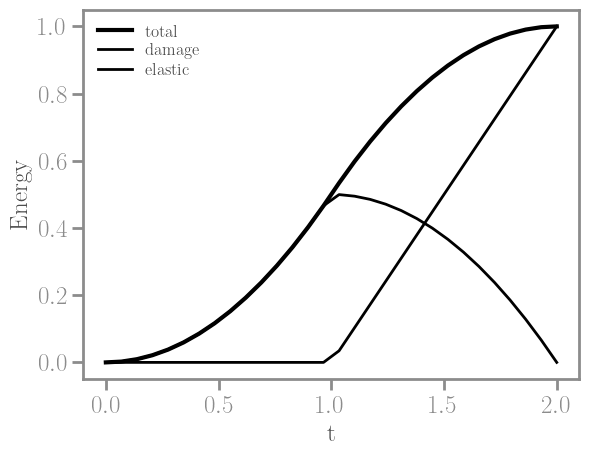

In [473]:
_en = system.energy_fc_alpha().subs(subs_homog_α)    \
            .subs(_matpar) \
            .replace(_a, system.model.a) \
            .replace(sp.Function('s'), atls.s)      \
            .replace(_w, system.model.w)  \
            .subs(_matpar)          \
    .subs({sp.symbols('α_t'): alpha})

_energy_damage = system.model._damage(state).subs(subs_homog_α).subs(_matpar) \
            .replace(_w, system.model.w)  \
            .subs({sp.symbols('α_t'): alpha})

_f = sp.lambdify(t, _en.subs(_matpar), 'numpy')
_f1 = sp.lambdify(t, _energy_damage, 'numpy')
plt.plot(_loads, _f(_loads), c='k', label='total', lw=3)
plt.plot(_loads, _f1(_loads), c='k', label='damage')
plt.plot(_loads, _f(_loads)-_f1(_loads), c='k', label='elastic')

plt.legend()
plt.ylabel('Energy')
plt.xlabel('t')

<>:34: SyntaxWarning: invalid escape sequence '\g'
<>:34: SyntaxWarning: invalid escape sequence '\g'
/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_517/1228249270.py:34: SyntaxWarning: invalid escape sequence '\g'
  ax.set_xlabel("$\gamma$")


Text(0.5, 0, '$\\gamma$')

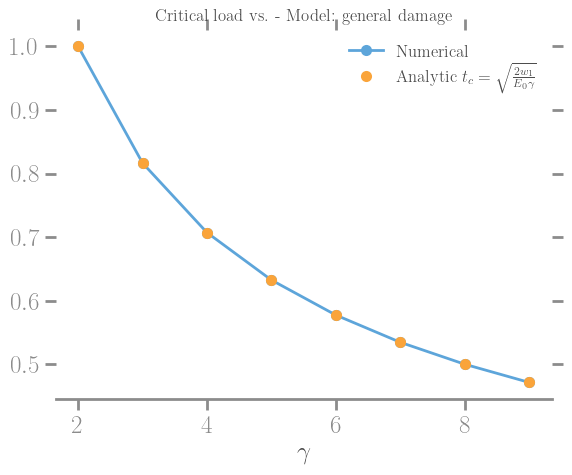

In [474]:
critical_loads = []
parameters = _matpar.copy()

for gamma in range(2, 10):
    parameters.update({γ: gamma})
    # print(model.critical_load(matpar=parameters)
    tc = system.critical_load(matpar=parameters)[0]
    _w1 = parameters["w1"]
    _E0 = parameters["E0"]
    critical_loads.append(
        {"γ": gamma, "tc": tc, "tc_analytical": sp.sqrt(2.0 * _w1 / (gamma * _E0))}
    )


fig, ax = plt.subplots()
ax.plot(
    [d["γ"] for d in critical_loads],
    [d["tc"] for d in critical_loads],
    label="Numerical",
    marker="o",
)
ax.plot(
    [d["γ"] for d in critical_loads],
    [d["tc_analytical"] for d in critical_loads],
    label="Analytic $t_c=\\sqrt{\\frac{2w_1}{E_0 \\gamma}}$",
    marker="o",
    ls="",
)
plt.legend()

visuals.setspines0()

ax.set_title(f"Critical load vs.  - Model: {atls.slug}")
ax.set_xlabel("$\gamma$")

In [475]:
_matpar

{'N': 4, 'γ': 2, 'E0': 1, 'w1': 1, 'L': 1}

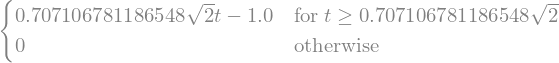

In [477]:
alpha = system.homogeneous_damage(_matpar)
alpha

<>:44: SyntaxWarning: invalid escape sequence '\g'
<>:44: SyntaxWarning: invalid escape sequence '\g'
/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_517/1331794418.py:44: SyntaxWarning: invalid escape sequence '\g'
  ax.set_xticks([0, float(tc), _matpar["γ"] * float(tc)], [0, "$t_c$", "$\gamma t_c$"])


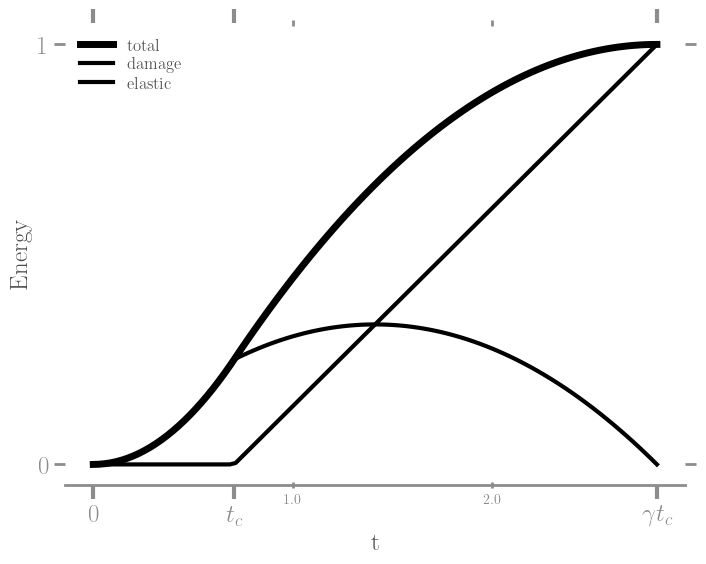

In [479]:
_N = 3
# _matpar = {"N": _N, "γ": 2, "E0": 1, "w1": 1, "L": 1}
_matpar = {"N": _N, "γ": 4, "E0": 1, "w1": 1, "L": 1}

atls = SymbolicDiscreteDamage(_matpar)
system = ModelAnalysis(atls)

tc = system.critical_load(matpar=_matpar)[0][0]
_loads = np.linspace(0.0, float(_matpar["γ"] * tc), 100)
alpha = system.homogeneous_damage(_matpar)

_en = (
    system.energy_fc_alpha()
    .subs(subs_homog_α)
    .subs(_matpar)
    .replace(sp.Function("a"), system.model.a)
    .replace(sp.Function("s"), system.model.s)
    .replace(sp.Function("w"), system.model.w)
    .subs(_matpar)
    .subs({sp.symbols("α_t"): alpha})
)

_energy_damage = (
    system.model._damage(system.state)
    .subs(subs_homog_α)
    .subs(_matpar)
    .replace(_w, system.model.w)
    .subs({sp.symbols("α_t"): alpha})
)


_f = sp.lambdify(t, _en.subs(_matpar), "numpy")
_f1 = sp.lambdify(t, _energy_damage, "numpy")
figure, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(_loads, _f(_loads), c="k", label="total", lw=5)
ax.plot(_loads, _f1(_loads), c="k", label="damage", lw=3)
ax.plot(_loads, _f(_loads) - _f1(_loads), c="k", label="elastic", lw=3)

ax.legend()
plt.ylabel("Energy")
plt.xlabel("t")

ax.set_xticks([0, float(tc), _matpar["γ"] * float(tc)], [0, "$t_c$", "$\gamma t_c$"])
ax.tick_params(axis="x", which="major", direction="out", length=10, width=3, colors="k")

ax.set_xticks(
    np.arange(0.0, _matpar["γ"] * float(tc)),
    np.arange(0.0, _matpar["γ"] * float(tc)),
    minor=True,
)
ax.tick_params(
    axis="x",
    which="minor",
    direction="inout",
    length=5,
    width=2,
    colors="k",
    labelsize=10,
)

plt.yticks([0, 1])

visuals.setspines0()

## Second order

### Bifurcations

Compute bifurcated solutions with $m$ damaging springs out of the available $N$, with $m<N$

In [304]:
_N = 3
# _matpar = {"N": _N, "γ": 2, "E0": 1, "w1": 1, "L": 1}
_matpar = {"N": _N, "γ": 2, "E0": 1, "w1": 1, "L": 1}


atls = SymbolicDiscreteDamage(_matpar)
system = ModelAnalysis(atls)
system.criterion().subs(_matpar)

In [305]:
_matpar["N"]

In [306]:
system.state

{'u': [u0, u1, u2], 'α': [α1, α2, α3], 'e': [e1, e2, e3]}

In [307]:
# we bifurcate m springs

m = 1

assert m < _matpar["N"]

In [308]:
bif_α, homo_α, bif_e, homo_e = system._state_split(m, _matpar)
print(f'set of bifurcated (evolving) springs {bif_α}')
print(f'set of stationary springs {homo_α}')

set of bifurcated (evolving) springs [α2]
set of stationary springs {α1, α3}


In [309]:
subs_bif_α, subs_bif_e = system._state_bifurcation_substitutions(m, _matpar)
# substitutions for damage and strain
subs_bif_α, subs_bif_e

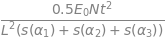

In [310]:
system._elastic_energy_fc_alpha()

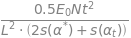

In [311]:
_elastic_en_bif_alpha = system._elastic_energy_fc_alpha().subs(subs_bif_α)
_elastic_en_bif_alpha

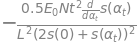

In [312]:
sp.diff(_elastic_en_bif_alpha.subs({sp.symbols('α^*'): 0}), sp.symbols('α_t'))

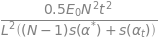

In [313]:
system._elastic_energy_m_bifurcations(m=m)

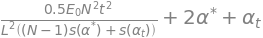

In [314]:
system.energy_m_bifurcations(m=m)

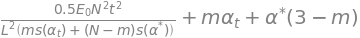

In [315]:
system.energy_m_bifurcations(sp.symbols("m"))

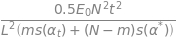

In [316]:
system._elastic_energy_m_bifurcations(sp.symbols("m"))

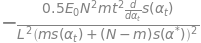

In [317]:
sp.diff(system._elastic_energy_m_bifurcations(sp.symbols('m')), sp.symbols('α_t'))


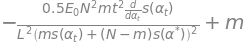

In [319]:
sp.diff(system.energy_m_bifurcations(sp.symbols("m")), sp.symbols("α_t"))

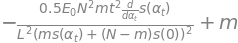

In [320]:
sp.diff(
    system.energy_m_bifurcations(sp.symbols("m")).subs({sp.symbols("α^*"): 0}),
    sp.symbols("α_t"),
)

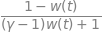

In [321]:
atls.a(sp.symbols('t'))

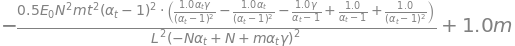

In [322]:
bif_crit_m = (
    sp.diff(
        system.energy_m_bifurcations(sp.symbols("m")).subs({sp.symbols("α^*"): 0}),
        sp.symbols("α_t"),
    )
    .replace(sp.Function("s"), atls.s)
    .replace(_w, atls.w)
    .simplify()
)

bif_crit_m

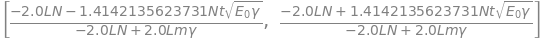

In [323]:
sp.solve(bif_crit_m, sp.symbols('α_t'))
# [1].simplify()

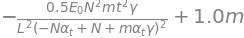

In [324]:
bif_crit_m.simplify()

In [325]:
sp.latex(bif_crit_m.simplify())

'- \\frac{0.5 E_{0} N^{2} m t^{2} γ}{L^{2} \\left(- N α_{t} + N + m α_{t} γ\\right)^{2}} + 1.0 m'

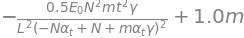

In [326]:
bif_crit_m.simplify()

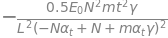

In [327]:
bif_crit_m.args[1].simplify()

In [328]:
num, den = sp.fraction(bif_crit_m.args[1].simplify())

In [329]:
den.factor(sp.symbols('α_t')) 

In [330]:
sp.latex(den.factor(sp.symbols('α_t')) )

'L^{2} \\left(N + α_{t} \\left(- N + m γ\\right)\\right)^{2}'

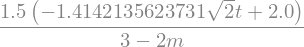

In [331]:
# sp.latex(
sp.solve(bif_crit_m, sp.symbols('α_t'))[1].simplify().subs(_matpar)
# )

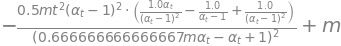

In [332]:
bif_crit_m = sp.diff(
    system.energy_m_bifurcations(sp.symbols('m')).subs({sp.symbols('α^*'): 0}) \
    , sp.symbols('α_t'))    \
        .replace(sp.Function('s'), atls.s)      \
        .replace(_w, system.model.w)         \
        .subs(_matpar).simplify()

bif_crit_m

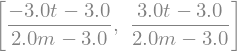

In [333]:
bif_m_solutions = sp.solve(bif_crit_m, sp.symbols('α_t'))
# bif_m_solutions[1]

bif_m_solutions

In [334]:
(bif_m_solutions[1]).subs(sp.symbols('m'), 1)

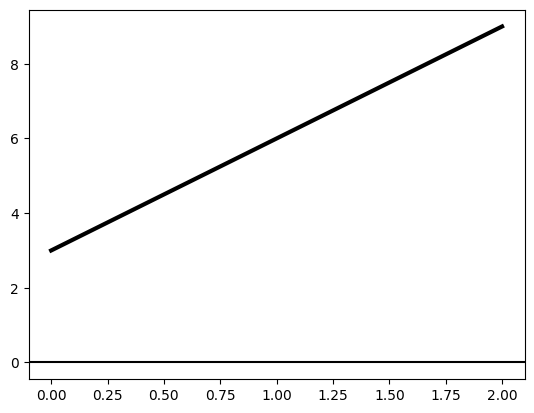

In [335]:
bif = bif_m_solutions[0].subs(sp.symbols('m'), 1)
_loads = np.linspace(0., float(γ.subs(_matpar)), 30)

_f = sp.lambdify(t, bif.subs(_matpar), 'numpy')
plt.plot(_loads, _f(_loads), c='k', lw=3)

plt.axhline(0, c='k')

3.0*(-t - 1)/(2.0*m - 3.0)
3.0*(t - 1)/(2.0*m - 3.0)
3.0*(-t - 1)/(2.0*m - 3.0)
3.0*(t - 1)/(2.0*m - 3.0)


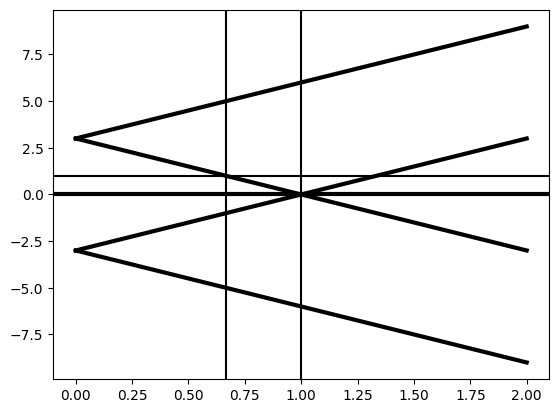

In [336]:
# sp.latex(
sols = sp.solve(bif_crit_m, sp.symbols('α_t'))
# )
# sols

for _m in range(1, N.subs(_matpar)):
    for sol in sols:
        print(sol.simplify().subs(_matpar))
        _f = sp.lambdify(t, sol.simplify().subs(_matpar).subs(sp.symbols('m'), _m), 'numpy')
        plt.plot(_loads, _f(_loads), c='k', lw=3)
        
plt.axhline(0, c='k', lw=3)
plt.axhline(1, c='k')
plt.axvline(1, c='k')
plt.axvline((γ/N).subs(_matpar), c='k')



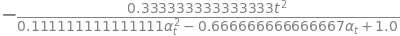

In [337]:
sp.diff(
    _elastic_en_bif_alpha.subs({sp.symbols('α^*'): 0}),
    sp.symbols('α_t')).simplify()   \
    .replace(sp.Function('s'), atls.s)      \
    .replace(_w, atls.w)                 \
        .subs(_matpar).doit().simplify()  

In [338]:
_bif_criterion_m_ela = sp.diff(
    _elastic_en_bif_alpha.subs({sp.symbols('α^*'): 0}),
    sp.symbols('α_t')).simplify()               \
    .replace(sp.Function('s'), atls.s)      \
    .replace(_w, atls.w)                 \
    .subs(_matpar).doit().simplify()  \
    
_bif_criterion_m_dam = sp.diff(
    atls._damage(state).subs(subs_bif_α).subs({sp.symbols('α^*'): 0})    \
        .replace(_w, atls.w).doit(), 
    sp.symbols('α_t'))


In [339]:
bif_solutions = sp.solve(_bif_criterion_m_ela + _bif_criterion_m_dam, sp.symbols('α_t'))

In [340]:
positive_solution_idx = np.where(np.array([sp.diff(b, t).subs(_matpar) for b in bif_solutions]) > 0)[0][0]

In [343]:
positive_solution_idx, bif_solutions[positive_solution_idx]

(1, 3.0*t + 3.0)

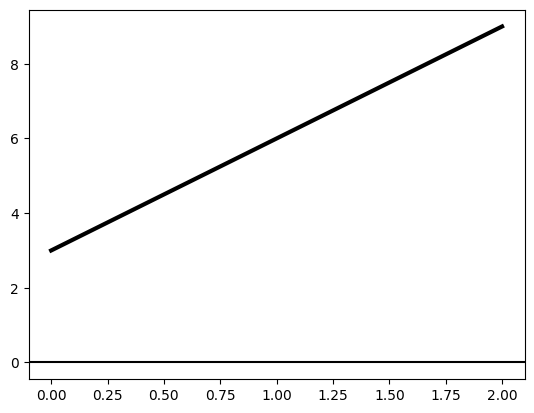

In [344]:
bif = bif_solutions[positive_solution_idx]
_loads = np.linspace(0.0, float(γ.subs(_matpar)), 30)

_f = sp.lambdify(t, bif.subs(_matpar), "numpy")
plt.plot(_loads, _f(_loads), c="k", lw=3)

plt.axhline(0, c="k")

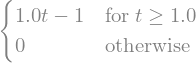

In [347]:
alpha

In [ ]:
atls._damage(state).subs(subs_bif_α).subs({sp.symbols('α_t'): 0})   \
            .subs(_matpar) \
            .replace(_w, atls.w)  \
            .replace(sp.symbols("a^*"), alpha)
            # .subs({sp.symbols('β'): alpha})


Piecewise((0.707106781186548*sqrt(2)*t - 1.0, t >= 0.707106781186548*sqrt(2)), (0, True))

In [364]:
_en_alpha_bif = (
    system.energy_fc_alpha()
    .subs(subs_bif_α)
    .subs({sp.symbols("α_t"): 0})
    .replace(_a, system.model.a)
    .replace(sp.Function("s"), atls.s)
    .replace(_w, system.model.w)
    .subs(_matpar)
    .replace(sp.symbols("α^*"), alpha)
    .simplify()
)

_energy_damage_bif = (
    system.model._damage(system.state)
    .subs(subs_bif_α)
    .subs({sp.symbols("α_t"): 0})
    .subs(_matpar)
    .replace(_w, system.model.w)
    .replace(sp.symbols("α^*"), alpha)
)
# .subs({sp.symbols('β'): alpha})



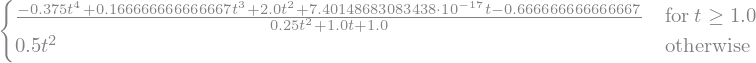

In [365]:
_en_alpha_bif


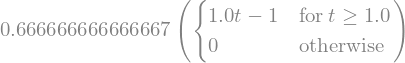

In [366]:
_energy_damage_bif

In [367]:
subs_bif_α

In [368]:
sp.srepr(_en_alpha_bif)

"Piecewise(ExprCondPair(Mul(Pow(Add(Mul(Float('0.25', precision=53), Pow(Symbol('t'), Integer(2))), Mul(Float('1.0', precision=53), Symbol('t')), Float('1.0', precision=53)), Integer(-1)), Add(Mul(Integer(-1), Float('0.375', precision=53), Pow(Symbol('t'), Integer(4))), Mul(Float('0.16666666666666666', precision=53), Pow(Symbol('t'), Integer(3))), Mul(Float('2.0', precision=53), Pow(Symbol('t'), Integer(2))), Mul(Float('7.4014868308343765e-17', precision=53), Symbol('t')), Float('-0.66666666666666663', precision=53))), GreaterThan(Symbol('t'), Float('1.0', precision=53))), ExprCondPair(Mul(Float('0.5', precision=53), Pow(Symbol('t'), Integer(2))), true))"

Text(0.5, 0, 't')

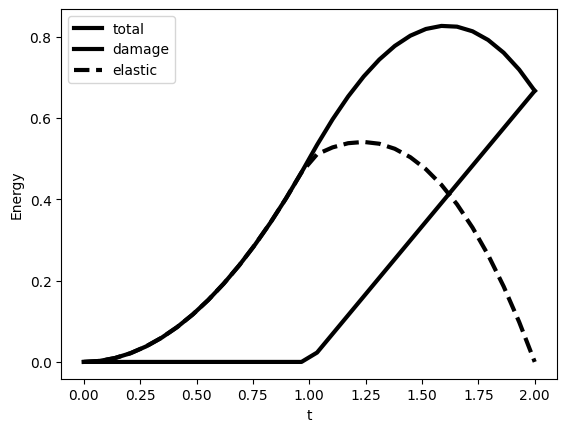

In [371]:
_f = sp.lambdify(t, _en_alpha_bif, "numpy")
_fd = sp.lambdify(t, _energy_damage_bif, "numpy")
plt.plot(_loads, _f(_loads), c="k", label="total", lw=3)
plt.plot(_loads, _fd(_loads), c="k", label="damage", lw=3)
plt.plot(_loads, _f(_loads) - _fd(_loads), c="k", label="elastic", lw=3, ls = '--')

plt.legend()
plt.ylabel("Energy")
plt.xlabel("t")

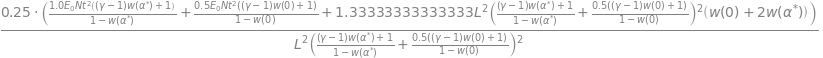

In [ ]:
# The energy of the bifurcated system

_en_alpha_bifurcations = system.energy_fc_alpha().subs(subs_bif_α).subs({sp.symbols('α_t'): 0})
_en_alpha_bifurcations  \
            .replace(_a, system.model.a) \
            .replace(sp.Function('s'), atls.s)      \
            

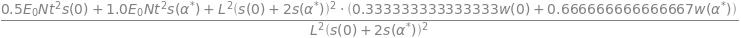

In [376]:
sp.simplify(_en_alpha_bifurcations) 

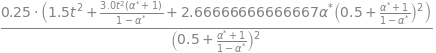

In [377]:
sym_en_alpha_bifurcations = sp.simplify(_en_alpha_bifurcations)      \
            .replace(_a, system.model.a)  \
            .replace(sp.Function('s'), atls.s)      \
            .replace(_w, system.model.w)  \
            .subs(_matpar)          \
            .doit()

sym_en_alpha_bifurcations

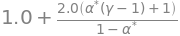

In [379]:
sum([system.model._s(αi) for αi in system.state["α"]])      \
            .replace(sp.Function('s'), atls.s)      \
            .replace(_w, system.model.w)  \
            .subs(subs_bif_α)           \
            .subs({sp.symbols('α_t'): 0})

<lambdifygenerated-83>:2: RuntimeWarning: divide by zero encountered in divide
  return 1.0 + 2.0*(Dummy_2180 + 1)/(1 - Dummy_2180)


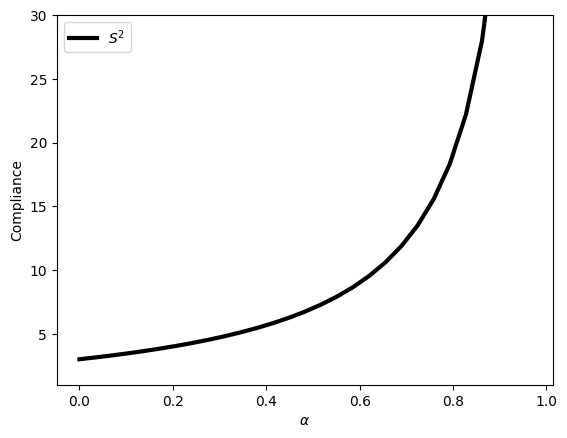

In [382]:
_compl_alpha = (
    (sum([system.model._s(αi) for αi in system.state["α"]]) ** 2)
    .replace(sp.Function("s"), atls.s)
    .replace(_w, system.model.w)
    .subs(subs_bif_α)
    .subs({sp.symbols("α_t"): 0})
    .subs(_matpar)
)

_f = sp.lambdify(sp.symbols("α^*"), _compl_alpha, "numpy")
_alphas = np.linspace(0.0, 1.0, 30)
plt.plot(_alphas, _f(_alphas), c="k", label="$S^2$", lw=3)

plt.legend()
plt.ylabel(f"Compliance")
plt.xlabel("$\\alpha$")
plt.ylim(1, 30)

<lambdifygenerated-85>:2: RuntimeWarning: divide by zero encountered in divide
  return 1.0 + 2.0*(select([greater_equal(t, 1.0),True], [1.0*t - 1,0], default=nan) + 1)/(1 - select([greater_equal(t, 1.0),True], [1.0*t - 1,0], default=nan))


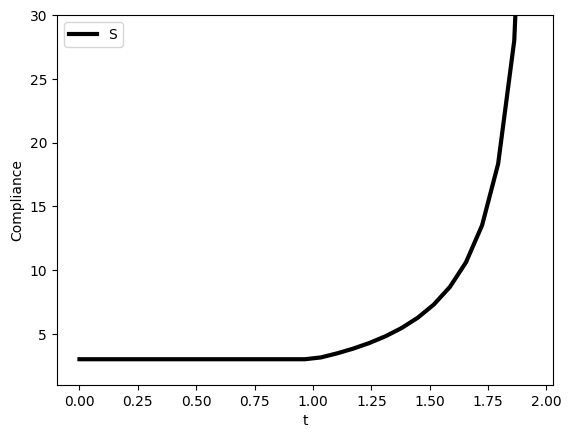

In [385]:
_S2 = (
    sum([system.model._s(αi) for αi in system.state["α"]])
    .replace(sp.Function("s"), atls.s)
    .replace(_w, system.model.w)
    .subs(subs_bif_α)
    .replace(sp.symbols("α^*"), alpha)
    .subs({sp.symbols("α_t"): 0})
)

_f = sp.lambdify(t, _S2.subs(_matpar), "numpy")
plt.plot(_loads, _f(_loads), c="k", label="S", lw=3)

plt.legend()
plt.ylabel(f"Compliance")
plt.xlabel("t")
plt.ylim(1, 30)

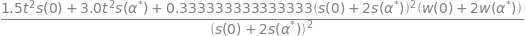

In [386]:
(system.energy_fc_alpha().subs(subs_bif_α).subs({sp.symbols('α_t'): 0})).subs(_matpar)

## Second variation

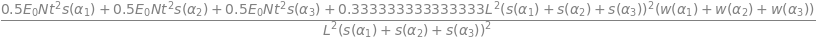

In [387]:
system.energy_fc_alpha()

In [388]:
small_hess = sp.hessian(system.energy_fc_alpha(), state["α"])

In [ ]:
subs_inverse = {sp.Function('s')(sp.Symbol(a.name)): 1/_a(a) for a in state["α"]}
subs_inverse


{s(α1): 1/a(α1), s(α2): 1/a(α2)}

In [ ]:
# subs_s_inverse = {sp.Function('s')(sp.Symbol(a.name)): 1/_a(a) for a in state["α"]}
subs_s_inverse = {sp.Function('a')(sp.Symbol(a.name)): 1/system.model._s(a) for a in state["α"]}
subs_s_inverse


{a(α1): 1/s(α1), a(α2): 1/s(α2)}

In [ ]:
system.energy_fc_alpha().subs(subs_inverse)

0.5*E0*N**2*t**2/(L**2*(1/a(α2) + 1/a(α1))**2*a(α2)) + 0.5*E0*N**2*t**2/(L**2*(1/a(α2) + 1/a(α1))**2*a(α1)) + w1*w(α1) + w1*w(α2)

In [ ]:
system.energy_fc_alpha().subs(subs_s_inverse)

0.5*E0*N**2*t**2*s(α1)/(L**2*(s(α1) + s(α2))**2) + 0.5*E0*N**2*t**2*s(α2)/(L**2*(s(α1) + s(α2))**2) + w1*w(α1) + w1*w(α2)

In [ ]:
subs_stiffness = {_a(a): system.model.s(a) for a in state["α"]}
subs_stiffness

{a(α1): 1.0*((γ - 1)*w(α1) + 1)/(1 - w(α1)),
 a(α2): 1.0*((γ - 1)*w(α2) + 1)/(1 - w(α2))}

In [ ]:
small_hess = sp.hessian(system.energy_fc_alpha().subs(subs_s_inverse), state["α"])
small_hess

Matrix([
[0.5*E0*N**2*t**2*Derivative(s(α1), (α1, 2))/(L**2*(s(α1) + s(α2))**2) - 1.0*E0*N**2*t**2*s(α1)*Derivative(s(α1), (α1, 2))/(L**2*(s(α1) + s(α2))**3) - 1.0*E0*N**2*t**2*s(α2)*Derivative(s(α1), (α1, 2))/(L**2*(s(α1) + s(α2))**3) - 2.0*E0*N**2*t**2*Derivative(s(α1), α1)**2/(L**2*(s(α1) + s(α2))**3) + 3.0*E0*N**2*t**2*s(α1)*Derivative(s(α1), α1)**2/(L**2*(s(α1) + s(α2))**4) + 3.0*E0*N**2*t**2*s(α2)*Derivative(s(α1), α1)**2/(L**2*(s(α1) + s(α2))**4) + w1*Derivative(w(α1), (α1, 2)),                                                                                                                                                                                                           -2.0*E0*N**2*t**2*Derivative(s(α1), α1)*Derivative(s(α2), α2)/(L**2*(s(α1) + s(α2))**3) + 3.0*E0*N**2*t**2*s(α1)*Derivative(s(α1), α1)*Derivative(s(α2), α2)/(L**2*(s(α1) + s(α2))**4) + 3.0*E0*N**2*t**2*s(α2)*Derivative(s(α1), α1)*Derivative(s(α2), α2)/(L**2*(s(α1) + s(α2))**4)],
[                          

In [ ]:
system.energy_fc_alpha().subs(subs_s_inverse)

0.5*E0*N**2*t**2*s(α1)/(L**2*(s(α1) + s(α2))**2) + 0.5*E0*N**2*t**2*s(α2)/(L**2*(s(α1) + s(α2))**2) + w1*w(α1) + w1*w(α2)

In [ ]:
small_hess[0, 0]

0.5*E0*N**2*t**2*Derivative(s(α1), (α1, 2))/(L**2*(s(α1) + s(α2))**2) - 1.0*E0*N**2*t**2*s(α1)*Derivative(s(α1), (α1, 2))/(L**2*(s(α1) + s(α2))**3) - 1.0*E0*N**2*t**2*s(α2)*Derivative(s(α1), (α1, 2))/(L**2*(s(α1) + s(α2))**3) - 2.0*E0*N**2*t**2*Derivative(s(α1), α1)**2/(L**2*(s(α1) + s(α2))**3) + 3.0*E0*N**2*t**2*s(α1)*Derivative(s(α1), α1)**2/(L**2*(s(α1) + s(α2))**4) + 3.0*E0*N**2*t**2*s(α2)*Derivative(s(α1), α1)**2/(L**2*(s(α1) + s(α2))**4) + w1*Derivative(w(α1), (α1, 2))

In [ ]:
sp.srepr(system.energy_fc_alpha())

"Add(Mul(Float('0.5', precision=53), Symbol('E0'), Pow(Symbol('L'), Integer(-2)), Pow(Symbol('N'), Integer(2)), Pow(Symbol('t'), Integer(2)), Pow(Add(Function('s')(Symbol('α1')), Function('s')(Symbol('α2'))), Integer(-2)), Function('a')(Symbol('α1')), Pow(Function('s')(Symbol('α1')), Integer(2))), Mul(Float('0.5', precision=53), Symbol('E0'), Pow(Symbol('L'), Integer(-2)), Pow(Symbol('N'), Integer(2)), Pow(Symbol('t'), Integer(2)), Pow(Add(Function('s')(Symbol('α1')), Function('s')(Symbol('α2'))), Integer(-2)), Function('a')(Symbol('α2')), Pow(Function('s')(Symbol('α2')), Integer(2))), Mul(Symbol('w1'), Function('w')(Symbol('α1'))), Mul(Symbol('w1'), Function('w')(Symbol('α2'))))"

In [ ]:
sp.diff(system.energy_fc_alpha().subs(subs_s_inverse), state["α"][0])

0.5*E0*N**2*t**2*Derivative(s(α1), α1)/(L**2*(s(α1) + s(α2))**2) - 1.0*E0*N**2*t**2*s(α1)*Derivative(s(α1), α1)/(L**2*(s(α1) + s(α2))**3) - 1.0*E0*N**2*t**2*s(α2)*Derivative(s(α1), α1)/(L**2*(s(α1) + s(α2))**3) + w1*Derivative(w(α1), α1)

In [ ]:
_i = sp.symbols('i')
sum = sp.summation(_a(_i), (_i, 0, len(state["α"])))
sum

a(0) + a(1) + a(2)

In [ ]:
system.energy_fc_alpha()

TypeError: 'Add' object is not callable